In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F

In [4]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.utils.data

In [5]:
CUDA = torch.cuda.is_available()
SEED = 1
USE_CONV = True

In [6]:
# hyperparameters
N = 4
k = 2
tau = 1.
HIDDEN_SIZE = 64

In [7]:
torch.manual_seed(SEED)
if CUDA:
    torch.cuda.manual_seed(SEED)

In [8]:
#transform
data_transforms = transforms.Compose([
        transforms.ToTensor(),
        lambda x: x>0.5,
        lambda x: x.float(),
    ])

In [9]:
# dataset loading
bsize = 100
train_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=True, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=False, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)

In [10]:
# TODO: UPDATE TO BINARY GUMBEL (REFER TO L0-REG PAPER)
# gumbel-softmax
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    v = Variable(torch.log(-torch.log(U + eps) + eps))
    if CUDA:
        v = v.cuda()
    return -v

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y

In [11]:
class Conv(nn.Module):
    def __init__(self):
        super(Conv, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        #self.conv2_drop = nn.Dropout2d()
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        #x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        inp = x.view(-1, 320)
        return inp

In [12]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        if USE_CONV:
            self.fc1 = nn.Linear(320, 512)
        else:
            self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, HIDDEN_SIZE)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        l = self.relu(self.fc2(h1))
        return l

In [13]:
class Tunnel(nn.Module):
    def __init__(self):
        super(Tunnel, self).__init__()
        self.fc1 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        l = self.relu(self.fc1(x))
        return l

In [14]:
class Output(nn.Module):
    def __init__(self):
        super(Output, self).__init__()
        self.fc1 = nn.Linear(HIDDEN_SIZE, 2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        l = h1.view(-1,2)
        return l

In [15]:
class Gate(nn.Module):
    def __init__(self):
        super(Gate, self).__init__()
        self.fc1 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
        
    def forward(self, x):
        return F.sigmoid(self.fc1(x))

In [16]:
def prob(outputs):
    outputs = [F.softmax(out, dim=-1) for out in outputs]
    return torch.cat(outputs, dim=1).view(-1, N, k)

def sample(l):
    gs = gumbel_softmax(l, tau)
    return gs.narrow(1,0,1)

# def signal(outputs):
#     outputs = [sample(out).narrow(1,0,1) for out in outputs]
#     return torch.cat(outputs, dim=1)

In [17]:
class RecDecoderHead(nn.Module):
    def __init__(self):
        super(RecDecoderHead, self).__init__()
        self.fc = nn.Linear(1, HIDDEN_SIZE)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.relu(self.fc(x))
    
class RecDecoderBody(nn.Module):
    def __init__(self):
        super(RecDecoderBody, self).__init__()
        self.fc = nn.Linear(1+HIDDEN_SIZE, HIDDEN_SIZE) # prev state + hidden
        self.relu = nn.ReLU()
    
    def forward(self, x):
        return self.relu(self.fc(x))
    
class RecDecoderTail(nn.Module):  
    def __init__(self):
        super(RecDecoderTail, self).__init__()
        self.fc1 = nn.Linear(HIDDEN_SIZE, 256)
        self.fc2 = nn.Linear(256, 512)      
        self.fc3 = nn.Linear(512, 784)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        h3 = self.fc3(h2)
        o = h3.view(-1,784)
        o = F.sigmoid(o)
        o = o.view(o.shape[0], 1, 28, 28) # reshape it be like original images
        return o

In [18]:
CV = Conv()
E = Encoder()
O0 = Output()
Os = [Output() for _ in range(N-1)]
Ts = [Tunnel() for _ in range(N-1)]
T1s = [Tunnel() for _ in range(N-1)]
Gs = [Gate() for _ in range(N-1)]
D_head = RecDecoderHead()
D_body = [RecDecoderBody() for _ in range(N-1)]
D_tail = RecDecoderTail()

In [19]:
if CUDA:
    CV = Conv()
    E.cuda()
    O0.cuda()
    [e.cuda() for e in Os]
    [e.cuda() for e in Ts]
    [e.cuda() for e in T1s]
    [e.cuda() for e in Gs]
    D_head.cuda()
    [e.cuda() for e in D_body]
    D_tail.cuda()

In [20]:
import os
os.system('mkdir -p checkpoint_recdecoder_decorrelated_new_encoder')
PATH = 'checkpoint_recdecoder_decorrelated_new_encoder/hd_vae'
def save_model():
    torch.save(CV.state_dict(), "{}_CV".format(PATH))
    torch.save(E.state_dict(), "{}_E".format(PATH))
    torch.save(O0.state_dict(), "{}_O0".format(PATH))
    
    def save_list(models, name):
        for i in range(len(models)):
            torch.save(models[i].state_dict(), "{}_{}_{}".format(PATH, name, i))
    
    save_list(Os, 'Os')
    save_list(Ts, 'Ts')
    save_list(T1s, 'T1s')
    save_list(Gs, 'Gs')
    
    torch.save(D_head.state_dict(), "{}_D_head".format(PATH))
    save_list(D_body, 'D_body')
    torch.save(D_tail.state_dict(), "{}_D_tail".format(PATH))
    
#save_model()

In [21]:
from itertools import product
    
log_two_pow_n = Variable(torch.Tensor([2**N]).log(), requires_grad=False)
if CUDA:
    log_two_pow_n = log_two_pow_n.cuda()

def get_dependent_prior_loss(x):
    acc = Variable(torch.zeros(2**N))
    if CUDA:
        acc = acc.cuda()
    acc_i = 0
    if USE_CONV:
        conv_features = CV(x)
    else:
        conv_features = x.view(-1, 784)
    for _path in product(range(2), repeat=N):
        path = Variable(torch.Tensor(_path), requires_grad=False)
        if CUDA:
            path = path.cuda()
        sofar = E(conv_features)
        outputs = [O0(sofar)]
        decoder_hidden = D_head(path[0])

        for n in range(len(Ts)-1):
            sofar = Ts[n](sofar)*Gs[n](decoder_hidden) # Kind of doing "teacher forcing"
            outputs.append(Os[n](sofar))
            decoder_hidden_inp = torch.cat([decoder_hidden, path[n]], -1)
            decoder_hidden = D_body[n](decoder_hidden_inp)
        
        sofar = Ts[-1](sofar)*Gs[-1](decoder_hidden) # Kind of doing "teacher forcing"
        outputs.append(Os[-1](sofar))
        
        q = prob(outputs)

        _idx = path.data
        select_mat = Variable(torch.stack([1-_idx, _idx]).t(), requires_grad=False)
        if CUDA:
            select_mat = select_mat.cuda()
        select_mat = select_mat.expand(torch.Size([x.shape[0]]) + select_mat.shape)
        probs = q.mul(select_mat).sum(-1) # shape (batch x N)
        log_q = (probs+1e-20).log().sum(-1) # shape (batch)
        kl_term = log_q.exp().mul(log_two_pow_n + log_q) # shape (batch)
        kl_term = kl_term.mean() # shape (1) - take sum over minibatch

        acc[acc_i] = kl_term
        acc_i += 1

    return acc.sum()

In [22]:
# TESTING
# Hacky! Getting a data point.
for batch_idx, (data, _) in enumerate(train_loader):
    data = Variable(data)
    if CUDA:
        data = data.cuda()
    x = data[0:4]
    break
    
get_dependent_prior_loss(x)

Variable containing:
1.00000e-04 *
  2.6094
[torch.FloatTensor of size 1]

In [23]:
x

Variable containing:
(0 ,0 ,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ⋮ 

(1 ,0 ,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ⋮ 

(2 ,0 ,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ⋮ 

(3 ,0 ,.,.) = 
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
     ...       ⋱       ...    
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
   0   0   0  ...    0   0   0
[torch.FloatTensor of si

In [24]:
# TODO
# objective
def loss_function(recon_x, x, q):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)/bsize # TODO eddie: changed from size_average=False
    # Assuming independent latent
#     KLD = torch.sum(q*(torch.log(q+1E-20)-np.log(1/k)))

    # Assuming dependent latent
    KLD = get_dependent_prior_loss(x)
    return BCE, KLD

In [25]:
params = [
    {'params':CV.parameters()},
    {'params':E.parameters()},
    {'params':O0.parameters()} 
] + [{'params':o.parameters()} for o in Os] \
  + [{'params':t.parameters()} for t in Ts] \
  + [{'params': g.parameters()} for g in Gs] \
  + [{'params': D_head.parameters()}, {'params': D_tail.parameters()}] \
  + [{'params': d_body.parameters()} for d_body in D_body]
optimizer = optim.Adam(params, lr=1e-4)

In [26]:
best_loss_sofar = 9999

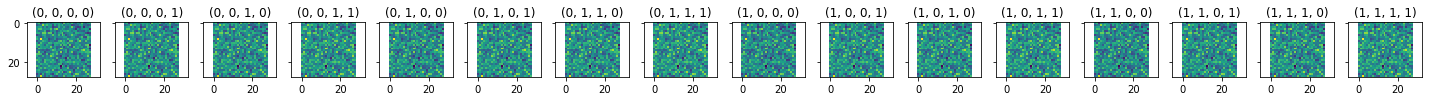

In [27]:
from itertools import product

def debug():
    f, axes = plt.subplots(1, 2**N, sharey=True, figsize=(25,1))
    kk = 0

    def make_variable(value):
        t = torch.Tensor([value]).type(torch.FloatTensor)
        t = t.unsqueeze(0)
        v = Variable(t)
        if CUDA:
            v = v.cuda()
        return v

    for path in product(range(2), repeat=N):
        decoder_hidden = D_head(make_variable(path[0]))
        for n in range(1, len(path)):
            decoder_hidden_inp = torch.cat([decoder_hidden, make_variable(path[n])], -1)
            decoder_hidden = D_body[n-1](decoder_hidden_inp)
        w = D_tail(decoder_hidden)

        ax = axes[kk]
        ax.set_title(path)
        ax.imshow(w.view(28,28).cpu().data.numpy())
        kk += 1
    plt.show()
    
debug()

In [28]:
def train(epoch):
    global best_loss_sofar
    train_bce_loss = 0
    train_kld_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        if CUDA:
            data = data.cuda()
        x = data
            
        optimizer.zero_grad()
        
        if USE_CONV:
            conv_features = CV(x)
        else:
            conv_features = x.view(-1, 784)
            
        sofar = E(conv_features)
        outputs = [O0(sofar)]
        samples = [sample(outputs[-1])]
        decoder_hidden = D_head(samples[-1])
        # TODO unroll this may make it faster
        for n in range(len(Ts)):
            sofar = Ts[n](sofar)*Gs[n](decoder_hidden)
            outputs.append(Os[n](sofar))
            samples.append(sample(outputs[-1]))
            
            decoder_hidden_inp = torch.cat([decoder_hidden, samples[-1]], -1)
            decoder_hidden = D_body[n](decoder_hidden_inp)
            
        recon_x = D_tail(decoder_hidden)
     
        bits = torch.cat(samples, dim=1) # for debugging only
        q = prob(outputs)

        BCE, KLD = loss_function(recon_x, x, q)
        loss = BCE + KLD
        loss.backward()
        optimizer.step()
        
        train_bce_loss += BCE.data[0]
        train_kld_loss += KLD.data[0]
        
#         if batch_idx % 200 == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tBCE loss: {:.6f}\tKLD loss: {:.6f}'.format(
#                 epoch+1, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader),
#                 BCE.data[0] / len(data),
#                 KLD.data[0] / len(data)))
            
    avg_bce_loss = train_bce_loss / len(train_loader.dataset)
    avg_kld_loss = train_kld_loss / len(train_loader.dataset)
    avg_loss = avg_bce_loss + avg_kld_loss
    print('====> Epoch: {} Average BCE loss: {:.4f}, Average KLD loss: {:.4f}, Total: {:.4f}'.format(
          epoch+1, avg_bce_loss, avg_kld_loss, avg_loss))
    
    if avg_loss < best_loss_sofar:
        print("Loss {} is better than previous best {}, saving model".format(avg_loss, best_loss_sofar))
        save_model()
        best_loss_sofar = avg_loss
        debug()
        
    return q, bits # debugging

====> Epoch: 1 Average BCE loss: 2.4790, Average KLD loss: 0.0024, Total: 2.4814
Loss 2.4813555259264417 is better than previous best 9999, saving model


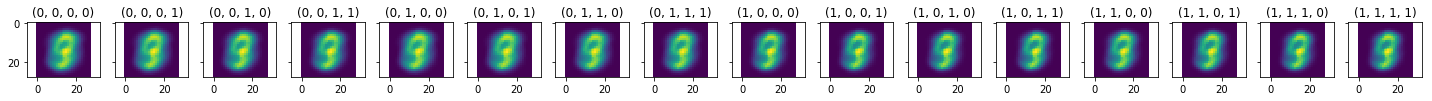

====> Epoch: 2 Average BCE loss: 2.0132, Average KLD loss: 0.0079, Total: 2.0211
Loss 2.0210502309699856 is better than previous best 2.4813555259264417, saving model


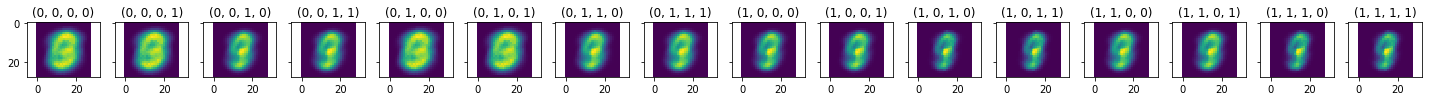

====> Epoch: 3 Average BCE loss: 1.9569, Average KLD loss: 0.0099, Total: 1.9668
Loss 1.9667917485713957 is better than previous best 2.0210502309699856, saving model


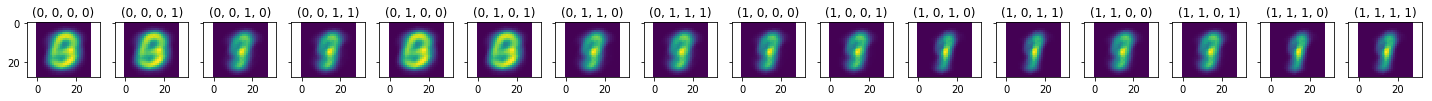

====> Epoch: 4 Average BCE loss: 1.9512, Average KLD loss: 0.0103, Total: 1.9615
Loss 1.961494502735138 is better than previous best 1.9667917485713957, saving model


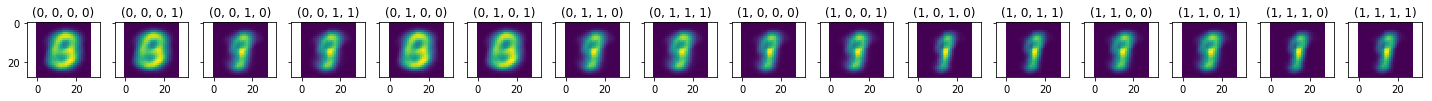

====> Epoch: 5 Average BCE loss: 1.9487, Average KLD loss: 0.0105, Total: 1.9592
Loss 1.959228363277515 is better than previous best 1.961494502735138, saving model


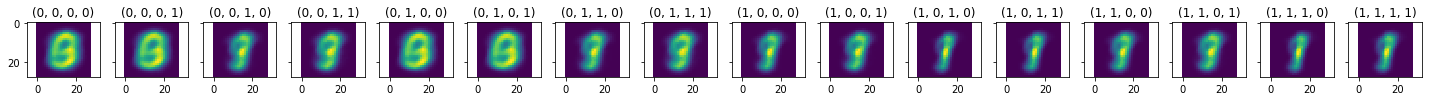

====> Epoch: 6 Average BCE loss: 1.9471, Average KLD loss: 0.0089, Total: 1.9560
Loss 1.9559664084007342 is better than previous best 1.959228363277515, saving model


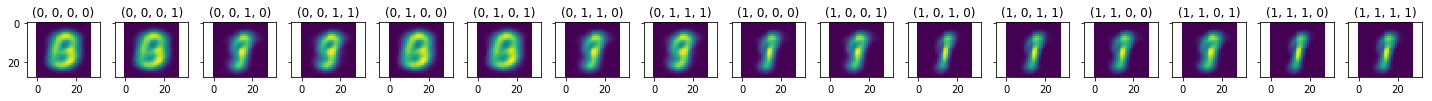

====> Epoch: 7 Average BCE loss: 1.9449, Average KLD loss: 0.0073, Total: 1.9522
Loss 1.9522229885985454 is better than previous best 1.9559664084007342, saving model


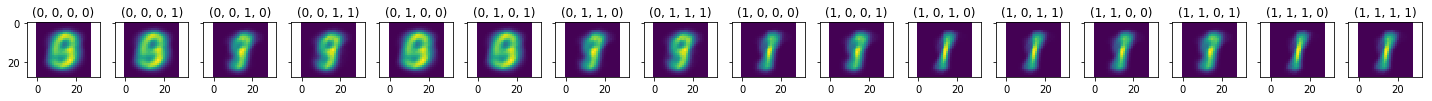

====> Epoch: 8 Average BCE loss: 1.9467, Average KLD loss: 0.0074, Total: 1.9541
====> Epoch: 9 Average BCE loss: 1.9528, Average KLD loss: 0.0074, Total: 1.9602
====> Epoch: 10 Average BCE loss: 1.9578, Average KLD loss: 0.0074, Total: 1.9652
CPU times: user 25min 24s, sys: 5min 25s, total: 30min 50s
Wall time: 24min 7s


In [29]:
%%time
for epoch in range(10):
    q, bits = train(epoch)

In [30]:
q

Variable containing:
( 0 ,.,.) = 
  3.9462e-06  1.0000e+00
  5.0000e-01  5.0000e-01
  1.2205e-01  8.7795e-01
  5.0000e-01  5.0000e-01

( 1 ,.,.) = 
  5.0000e-01  5.0000e-01
  5.0000e-01  5.0000e-01
  9.9999e-01  1.4338e-05
  2.5081e-05  9.9997e-01

( 2 ,.,.) = 
  2.2424e-10  1.0000e+00
  5.0000e-01  5.0000e-01
  2.0033e-04  9.9980e-01
  5.0000e-01  5.0000e-01

( 3 ,.,.) = 
  5.0000e-01  5.0000e-01
  5.0000e-01  5.0000e-01
  1.0000e+00  1.0958e-06
  8.8883e-08  1.0000e+00

( 4 ,.,.) = 
  4.0402e-09  1.0000e+00
  5.0000e-01  5.0000e-01
  2.6446e-03  9.9736e-01
  5.0000e-01  5.0000e-01

( 5 ,.,.) = 
  8.0340e-08  1.0000e+00
  5.0000e-01  5.0000e-01
  2.6513e-02  9.7349e-01
  5.0000e-01  5.0000e-01

( 6 ,.,.) = 
  3.3043e-07  1.0000e+00
  5.0000e-01  5.0000e-01
  1.0745e-01  8.9255e-01
  5.0000e-01  5.0000e-01

( 7 ,.,.) = 
  2.2473e-08  1.0000e+00
  5.0000e-01  5.0000e-01
  2.4356e-02  9.7564e-01
  5.0000e-01  5.0000e-01

( 8 ,.,.) = 
  2.5643e-08  1.0000e+00
  5.0000e-01  5.0000e-01
  1.

In [31]:
bits

Variable containing:
    0     0     0     1
    0     1     1     0
    0     0     0     1
    0     0     1     0
    0     0     0     1
    0     1     0     1
    0     1     1     0
    0     0     0     0
    0     1     0     1
    0     0     0     1
    0     1     0     1
    0     1     0     0
    0     1     1     0
    0     0     0     0
    0     0     0     1
    0     1     0     1
    0     0     1     1
    1     1     0     0
    0     1     0     1
    0     1     0     0
    0     0     0     1
    0     0     0     0
    0     1     1     0
    0     1     0     1
    0     0     0     0
    0     1     0     1
    0     1     0     0
    0     1     0     1
    0     1     1     1
    0     0     0     1
    0     1     0     0
    0     0     0     1
    0     0     0     1
    0     0     1     0
    0     0     1     0
    0     1     0     1
    0     0     0     1
    0     0     0     0
    0     1     0     1
    0     0     0     0
    0     1     0  